<a href="https://colab.research.google.com/github/jack0928/computer-vision-fundamentals/blob/main/05_yolo_v3_object_detection_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

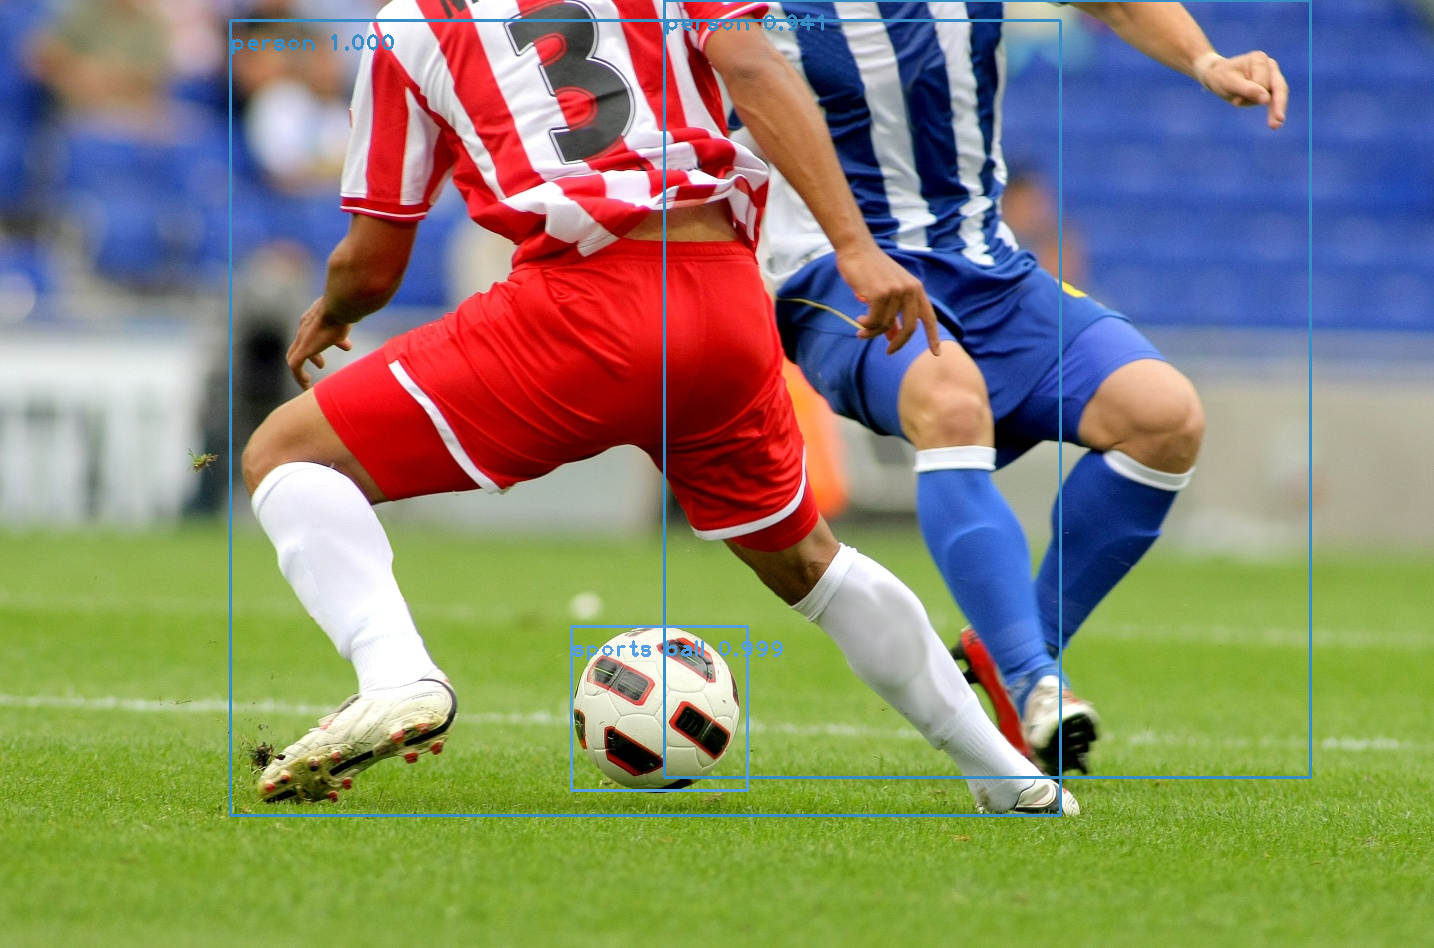

In [5]:
import numpy as np
import cv2 as cv
import sys
from google.colab.patches import cv2_imshow


def construct_yolo_v3():
    # COCO 데이터셋의 클래스 이름 로드
    f = open('coco_names.txt', 'r')
    class_names = [line.strip() for line in f.readlines()]

    # YOLOv3 모델 로드 (구조 + 가중치)
    model = cv.dnn.readNet('yolov3.weights', 'yolov3.cfg')

    # 전체 레이어 이름 가져오기
    layer_names = model.getLayerNames()

    # YOLO 출력 레이어 이름 가져오기
    out_layers = [layer_names[i - 1] for i in model.getUnconnectedOutLayers()]

    return model, out_layers, class_names


def yolo_detect(img, yolo_model, out_layers):
    # 원본 이미지 크기
    height, width = img.shape[0], img.shape[1]

    # 이미지를 YOLO 입력 형식(blob)으로 변환
    test_img = cv.dnn.blobFromImage(
        img,
        scalefactor=1.0 / 256,
        size=(448, 448),
        mean=(0, 0, 0),
        swapRB=True
    )

    # YOLO 모델에 입력
    yolo_model.setInput(test_img)

    # YOLO 추론 실행 (출력 레이어에서 결과 받음)
    output3 = yolo_model.forward(out_layers)

    box, conf, id = [], [], []  # 박스 좌표, 신뢰도, 클래스 번호

    # YOLO 출력 해석
    for output in output3:
        for vec85 in output:
            # vec85 구조:
            # [cx, cy, w, h, objectness, class1, class2, ...]
            scores = vec85[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            # 신뢰도 50% 이상만 사용
            if confidence > 0.5:
                # 중심 좌표 → 실제 픽셀 좌표
                centerx = int(vec85[0] * width)
                centery = int(vec85[1] * height)

                # 박스 크기
                w = int(vec85[2] * width)
                h = int(vec85[3] * height)

                # 좌상단 좌표
                x = int(centerx - w / 2)
                y = int(centery - h / 2)

                # 박스 정보 저장
                box.append([x, y, x + w, y + h])
                conf.append(float(confidence))
                id.append(class_id)

    # Non-Maximum Suppression (겹치는 박스 제거)
    ind = cv.dnn.NMSBoxes(box, conf, 0.5, 0.4)

    # 최종 결과 구성
    objects = [
        box[i] + [conf[i]] + [id[i]]
        for i in range(len(box)) if i in ind
    ]

    return objects


# ----------------- 메인 코드 -----------------

# YOLO 모델 생성
model, out_layers, class_names = construct_yolo_v3()

# 클래스마다 랜덤 색상 생성
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

# 이미지 읽기
img = cv.imread('soccer.jpeg')
if img is None:
    sys.exit('파일이 없습니다.')

# YOLO로 물체 검출
res = yolo_detect(img, model, out_layers)

# 검출된 물체를 이미지에 표시
for i in range(len(res)):
    x1, y1, x2, y2, confidence, id = res[i]
    text = f"{class_names[id]} {confidence:.3f}"

    cv.rectangle(img, (x1, y1), (x2, y2), colors[id], 2)
    cv.putText(
        img,
        text,
        (x1, y1 + 30),
        cv.FONT_HERSHEY_PLAIN,
        1.5,
        colors[id],
        2
    )

# 결과 출력
cv2_imshow(img)